In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
import pandas as pd 
import numpy as np
from sklearn.utils import shuffle

In [3]:
canDF = pd.read_csv('/gdrive/MyDrive/classCancelled.csv')

In [4]:
df = pd.read_csv('/gdrive/MyDrive/Classification_cleaned_data_with_outliers_01.csv')

In [5]:
df = df.append(canDF)

In [6]:
weatherdf = pd.read_csv('/gdrive/MyDrive/weather.csv')

In [7]:
weatherdf = weatherdf[['date','airport_code','visibility','value']]


In [8]:
weatherdf = weatherdf.rename({'date':'fl_date','airport_code':'origin'},axis=1)


In [9]:
df = df.merge(weatherdf, on=['fl_date','origin'])


In [10]:
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [11]:
df['op_unique_carrier'] = df.op_unique_carrier.astype('category').cat.codes.astype('category')
df['origin'] = df.origin.astype('category').cat.codes.astype('category')
df['dest'] = df.dest.astype('category').cat.codes.astype('category')
df['visibility'] = df.visibility.astype('category').cat.codes

In [12]:
df['cancelled'] = df['cancelled'].fillna(0)

In [13]:
cancelledDF = df.loc[df['cancelled'] == 1]
notCancelledDF = df.loc[df['cancelled'] == 0].sample(n=126468,random_state=42)
df = pd.concat([cancelledDF, notCancelledDF])

In [14]:
df.cancelled.value_counts()

0.0    126468
1.0    126468
Name: cancelled, dtype: int64

In [15]:
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
df = df.dropna(axis=1)

In [17]:
df = df.sample(frac=1).reset_index(drop=True)

In [18]:
X,y = df.drop('cancelled',axis=1),df['cancelled']

In [19]:
def value(row):
  if 'snow' in row['value']:
    return 'Snow'
  elif 'rain' in row['value']:
    return 'Rain'
  elif 'showers' in row['value']:
    return 'Rain'
  elif 'possible' in row['value']:
    return 'Rain'
  elif 'drizzle' in row['value']:
    return 'Rain'
  elif 'sleet' in row['value']:
    return 'Rain/Snow'
  elif 'blizzard' in row['value']:
    return 'Snow'
  else:
    return row['value']

In [20]:
X['value'] = X.apply(value,axis=1)
X['value'] = X.value.astype('category').cat.codes



In [22]:
X['Numerical_Week']= (pd.to_datetime(X['fl_date']).dt.weekofyear)
X['Season']= (pd.to_datetime(X['fl_date']).dt.month - 1) // 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [23]:
X['Weekday'] = pd.to_datetime(X['fl_date']).dt.dayofweek

In [24]:
X = X.drop(['fl_date','mkt_unique_carrier'],axis=1)

In [25]:
# X = X.drop(['crs_dep_time','origin','dest','op_unique_carrier','day','year','dep_time','arr_time','sumDelays','crs_arr_time','weekday'],axis=1)

In [26]:
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import r2_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
import xgboost as xg

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [28]:
from sklearn.metrics import mean_squared_error,accuracy_score

In [29]:
model = RandomForestClassifier()

In [30]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
model.score(X_test,y_test)

0.7889194923630422

In [31]:
print("Accuracy score:", accuracy_score(y_true=y_test,y_pred=y_pred))

Accuracy score: 0.7889194923630422


In [32]:
confusion_matrix(y_true=y_test,y_pred=y_pred)

array([[29407,  8570],
       [ 7447, 30457]])

In [33]:
model = GradientBoostingClassifier(n_estimators=150,learning_rate=1.5,random_state=1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
model.score(X_test,y_test)

0.745311738116261

In [34]:
print("Accuracy score:", accuracy_score(y_true=y_test,y_pred=y_pred))

Accuracy score: 0.745311738116261


In [35]:
confusion_matrix(y_true=y_test,y_pred=y_pred)

array([[27719, 10258],
       [ 9068, 28836]])

In [36]:
import xgboost as xgb

In [37]:
X.columns

Index(['op_unique_carrier', 'op_carrier_fl_num', 'origin', 'crs_dep_time',
       'dest', 'crs_arr_time', 'distance', 'visibility', 'value',
       'Numerical_Week', 'Season', 'Weekday'],
      dtype='object')

In [38]:
import lightgbm

In [39]:
model = lightgbm.LGBMClassifier(n_estimators=400,random_state=12)

In [40]:
model.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=400, n_jobs=-1, num_leaves=31, objective=None,
               random_state=12, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [41]:
y_pred = model.predict(X_test)
model.score(X_test,y_test)

0.7895520617809465

In [42]:
print("Accuracy score:", accuracy_score(y_true=y_test,y_pred=y_pred))

Accuracy score: 0.7895520617809465


In [43]:
confusion_matrix(y_true=y_test,y_pred=y_pred)

array([[28929,  9048],
       [ 6921, 30983]])

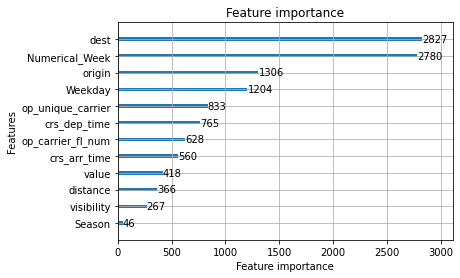

In [44]:
lightgbm.plot_importance(model)